In [ ]:
# import pandas as pd
import time
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
# from google.colab import files
import librosa                            # Параметризация аудио
import librosa.display                    # Визуализация аудио
import matplotlib.pyplot as plt           # Отрисовка графиков
import IPython.display as ipd             # Проигрывание аудио в colab
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pickle
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, SimpleRNN, Conv2D, MaxPooling2D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Нормирование сигнала
from sklearn.preprocessing import minmax_scale, scale

%matplotlib inline

In [3]:
# FILE_DIR = './subset_data'
FILE_DIR = './equals'
CLASS_LIST = os.listdir(FILE_DIR)
CLASS_LIST.sort()
CLASS_COUNT = len(CLASS_LIST)
CLASS_FILES = 507                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 456               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 200                         # Анализируемая длительность аудиосигнала
N_FFT = 4096                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 256                          # Объем данных для расчета одного набора признаков

In [75]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)

    # Сборка признаков в общий список:
    # На один файл несколько векторов признаков, количество определяется
    # продолжительностью аудио и параметром hop_length в функциях расчета признаков
    features = {'rmse': rmse,
                'spct': spec_cent,
                'spbw': spec_bw,
                'roff': rolloff,
                'zcr' : zcr,
                'mfcc': mfcc,
                'stft': chroma_stft}

    return features

In [76]:
# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

In [83]:
# Проверка параметризации одного произведения
y, sr = librosa.load(f'{FILE_DIR}/nontargets/2957804404.mp3', mono=True, duration=DURATION_SEC)
features = get_features(y, sr)

In [84]:
print(len(y), sr)

4410000 22050


In [85]:
print({k: v.shape for k, v in features.items()})

{'rmse': (1, 17227), 'spct': (1, 17227), 'spbw': (1, 17227), 'roff': (1, 17227), 'zcr': (1, 17227), 'mfcc': (20, 17227), 'stft': (12, 17227)}


In [86]:
# Проверка формирования набора признаков
feature_set = stack_features(features)
feature_set.shape

(17227, 37)

In [88]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

In [89]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 file_index,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    if class_name == "nontargets":
        file_name = nontargets_data[file_index]
    # elif class_name == "secondarytargets":
    #     file_name = secondtargets_data[file_index]
    elif class_name == "targets":
        file_name = targets_data[file_index]
    else:
        raise ValueError(f"Unknown class name: {class_name}")
    # Извлечение имени произведения
    song_name = f'{FILE_DIR}/{class_name}/{file_name}'

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index,
                                                        song_name,
                                                        duration_sec)

    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

In [90]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,          # начальный индекс аудиофайла
                 file_index_end,            # конечный индекс аудиофайла (не достигая)
                 duration_sec=DURATION_SEC  # длительность аудио в секундах
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in range(len(CLASS_LIST)):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_index, file_index, duration_sec)
            x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
            y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

In [91]:
# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = extract_data(0, FILE_INDEX_TRAIN_SPLIT)

Жанр nontargets готов -> 4322 c
Жанр targets готов -> 4401 c


In [92]:
import pickle
# Сохранение/восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов
with open('F:/model_data_all/audio_data_equal_200sec.pickle', 'wb') as f:
    pickle.dump((x_train_data, y_train_data), f)

In [97]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

In [98]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

In [2]:
# model = load_model('./model_data_all/model_audio_mean_200sec.h5')
with open('./model_data_all/audio_train_val_mean_200sec.pickle', 'rb') as f:
    x_train, y_train, x_val, y_val, x_scaler = pickle.load(f)

In [3]:
print(x_train.shape)

(14139921, 37)


In [4]:
# Проверка нормирования
print(x_train[0])

[-0.16565335 -1.0094718  -1.1203183  -1.463343   -0.54107213 -0.15085064
  0.7130128   0.90396893  0.2418371   0.19400796  0.02931678 -1.9796288
 -2.5388017   0.18801078  0.25659305 -1.9824933  -0.9630995  -0.29489824
 -1.0154761   0.8849885   1.2570957  -1.9430696  -1.5119117   1.693002
  0.99833953  0.04346428 -0.45601478 -0.7338905  -0.72320956 -0.3664999
  0.35816887  0.22064579 -0.11589335  0.01527757  1.3508028   1.8705864
  0.02057982]


In [5]:
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(14139921, 37) float32
(14139921, 2) float32

(1571103, 37) float32
(1571103, 2) float32


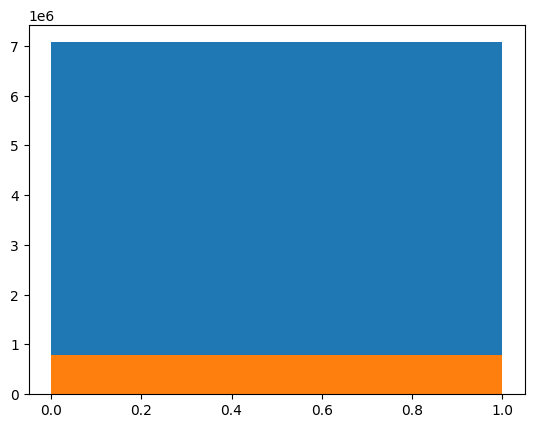

In [6]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_train, axis=1), bins=2)
plt.hist(np.argmax(y_val, axis=1), bins=2)
# plt.xticks([0, 1])
plt.show()

In [7]:
# Функция компиляции и обучения модели с одними и теми же параметрами

def compile_train(model,           # модель нейронной сети
                  epochs=100,      # количество эпох обучения
                  batch_size=1024  # размер батча
                  ):
    # Компиляция
    model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    # Обучение
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графика обучения
    plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
    plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
    plt.show()

Epoch 1/100
13809/13809 [==============================] - 176s 13ms/step - loss: 0.6311 - accuracy: 0.6206 - val_loss: 0.6114 - val_accuracy: 0.6440
Epoch 2/100
13809/13809 [==============================] - 176s 13ms/step - loss: 0.5998 - accuracy: 0.6568 - val_loss: 0.5888 - val_accuracy: 0.6688
Epoch 3/100
13809/13809 [==============================] - 175s 13ms/step - loss: 0.5777 - accuracy: 0.6788 - val_loss: 0.5701 - val_accuracy: 0.6861
Epoch 4/100
13809/13809 [==============================] - 176s 13ms/step - loss: 0.5578 - accuracy: 0.6970 - val_loss: 0.5516 - val_accuracy: 0.7017
Epoch 5/100
13809/13809 [==============================] - 175s 13ms/step - loss: 0.5387 - accuracy: 0.7129 - val_loss: 0.5337 - val_accuracy: 0.7170
Epoch 6/100
13809/13809 [==============================] - 139s 10ms/step - loss: 0.5209 - accuracy: 0.7270 - val_loss: 0.5178 - val_accuracy: 0.7293
Epoch 7/100
13809/13809 [==============================] - 134s 10ms/step - loss: 0.5049 - accuracy:

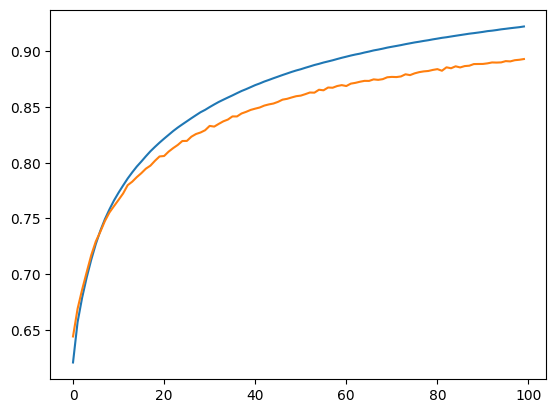

In [8]:
# Сеть с измененным количеством нейронов в слоях и нормализацией после каждого слоя

input1 = Input(x_train.shape[1:])

x1 = Dense(1024, activation="elu")(input1)
x1 = BatchNormalization()(x1)
x1 = Dense(1024, activation="elu")(x1)
x1 = BatchNormalization()(x1)

x2 = Dense(1024, activation="elu")(input1)
x2 = BatchNormalization()(x2)
x2 = Dense(160, activation="softmax")(x2)
x2 = BatchNormalization()(x2)

x3 = Dense(1024, activation="elu")(input1)
x3 = BatchNormalization()(x3)
x3 = Dense(400, activation="softmax")(x3)
x3 = BatchNormalization()(x3)

x4 = Dense(160, activation="softmax")(input1)
x4 = BatchNormalization()(x4)

x5 = Dense(400, activation="softmax")(input1)
x5 = BatchNormalization()(x5)

x6 = Dense(40, activation="softmax")(input1)
x6 = BatchNormalization()(x6)

x7 = Dense(1024, activation="elu")(input1)
x7 = BatchNormalization()(x7)
x7 = Dense(40, activation="softmax")(x7)
x7 = BatchNormalization()(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = BatchNormalization()(x)
x = Dense(512, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(2, activation='softmax')(x)

model = Model(input1, x)

compile_train(model)

In [9]:
# Сохранение/восстановление модели и выборок

model.save('./model_data_all2/model_audio_89%.h5')
with open('./model_data_all2/audio_train_val_89%.pickle', 'wb') as f:
    pickle.dump((x_train, y_train, x_val, y_val, x_scaler), f)